# loading modules

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import silhouette_score


import scVI
from benchmarking import *
from helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# parameters

In [3]:
batch_size = 128
learning_rate = 0.0005
epsilon = 0.01

# import data

In [4]:
#expression data
data_path = "/home/ubuntu/single-cell-scVI/data/bipolar/"
expression_train = scipy.sparse.load_npz(data_path + "data_train.npz").A
expression_test = scipy.sparse.load_npz(data_path + "data_test.npz").A

# batch info
b_train = np.loadtxt(data_path + "batch_train") - 1
b_test = np.loadtxt(data_path + "batch_test") - 1

#cluster info
c_train = np.loadtxt(data_path + "c_train")
c_test = np.loadtxt(data_path + "c_test")

# imputation dataset
X_zero, i, j, ix = \
        scipy.sparse.load_npz(data_path + "imputation/X_zero.npz").A,\
        np.load(data_path + "imputation/i.npy"), \
        np.load(data_path + "imputation/j.npy"), \
        np.load(data_path + "imputation/ix.npy")

# Computational graph

In [5]:
tf.reset_default_graph()
l_mean, l_var = np.mean(np.log(np.sum(expression_train, axis=1))), np.var(np.log(np.sum(expression_train, axis=1)))
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
batch_ind = tf.placeholder(tf.int32, [None], name='b_ind')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, phase=training_phase, optimize_algo=optimizer,  \
                          library_size_mean=l_mean, library_size_var=l_var, dispersion="gene")

# Session creation
sess = tf.Session()

Running scVI on 13166 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [6]:
sess.run(tf.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 120) #batch=(b_train, b_test))

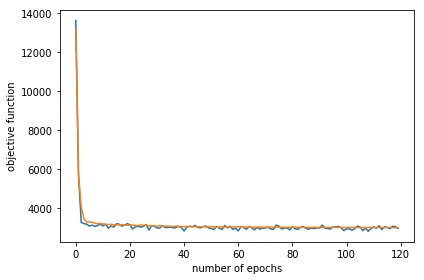

In [7]:
plot_training_info(result)

# Evaluation methods

In [8]:
latent = eval_latent(model, expression_train, sess) #, batch=b_train)
print cluster_scores(latent, len(np.unique(c_train)), c_train)
print entropy_batch_mixing(latent, b_train)
print silhouette_score(latent, b_train)

[0.26030374, 0.78770354382506136, 0.49736069004851868]
0.0709799311042
0.110213


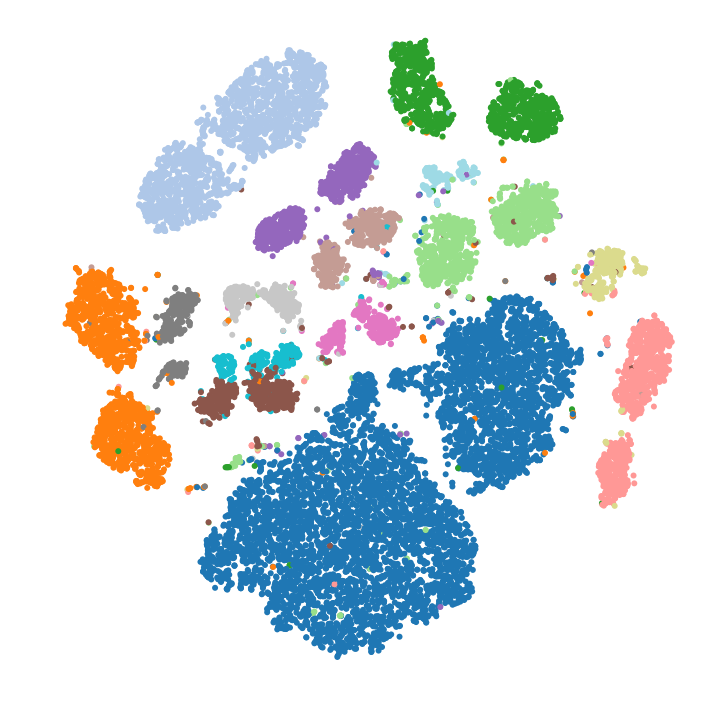

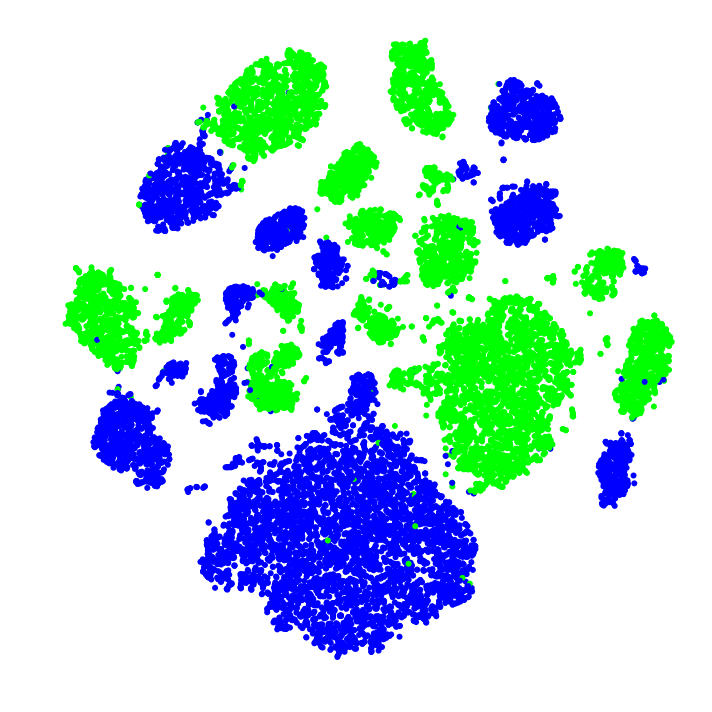

In [9]:
tsne = show_tSNE(latent, c_train, cmap=plt.get_cmap("tab20", 15), return_tSNE=True)
#plt.savefig("scVI_tSNE_bipolar_clusters.pdf", dpi=300)
plt.show()
show_tSNE(tsne, b_train, cmap=plt.get_cmap("brg", 2))
#plt.savefig("scVI_tSNE_bipolar_batch.pdf", dpi=300)

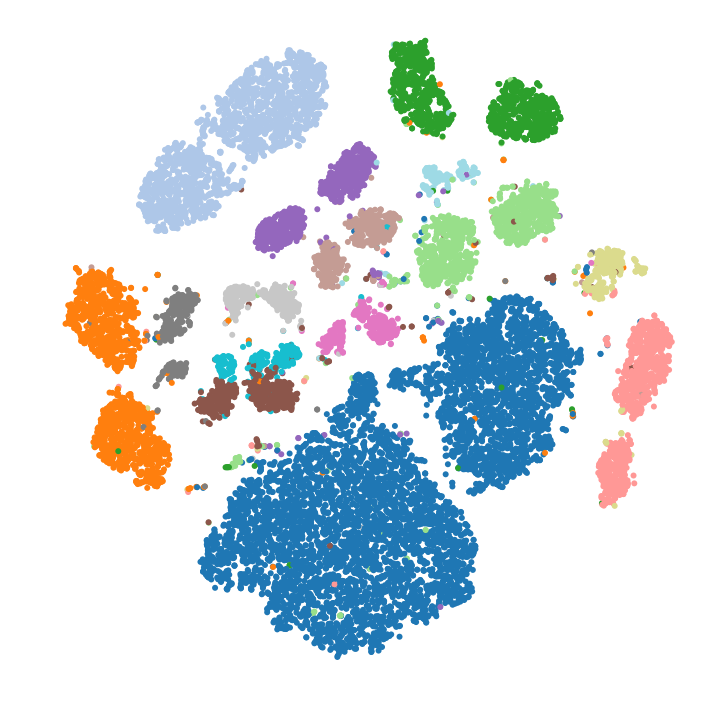

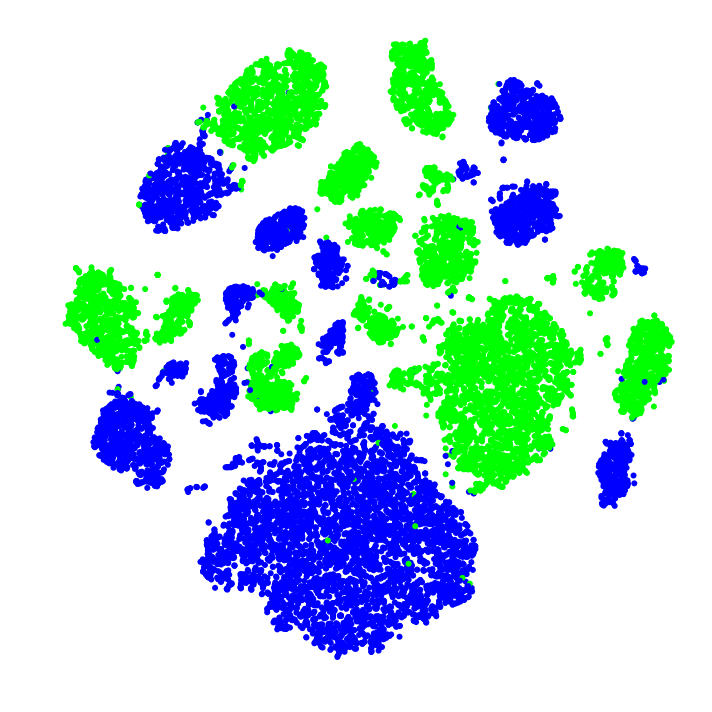

In [10]:
show_tSNE(tsne, c_train, cmap=plt.get_cmap("tab20", 15), return_tSNE=True)
plt.savefig("scVI_no_batch_tSNE_bipolar_clusters.pdf", dpi=300)
plt.show()
show_tSNE(tsne, b_train, cmap=plt.get_cmap("brg", 2))
plt.savefig("scVI_no_batch_tSNE_bipolar_batch.pdf", dpi=300)

In [11]:
sess.run(tf.global_variables_initializer())
res = train_model(model, (X_zero, expression_test), sess, 120, batch=(b_train, b_test))
eval_imputed_data(model, (X_zero, i, j, ix), expression_train, sess, batch=b_train)

0.25449681282043457